In [1]:
# Main imports
import curiosidade
import torch
import torch.nn


# Example imports
import functools

import numpy as np
import torch.nn.functional as F
import sentence_transformers
import datasets
import torchmetrics
import matplotlib.pyplot as plt
import seaborn as sns

/media/nvme/prober/venvs/py3.9.10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup pretrained model

In [2]:
sbert = sentence_transformers.SentenceTransformer("distilbert-base-nli-mean-tokens")

tokenizer = sbert.tokenizer
bert = sbert.get_submodule("0")

## Setup probing tasks

### Set up probing dataset for SentLen task

In [3]:
dataset_train, dataset_test = datasets.load_dataset("imdb", split=["train", "test"])

def tokenize_fn(item):
    sentlen_label = min(len(tokenizer.encode(item["text"])), 512)
    sentlen_label = float(max(1, np.ceil(sentlen_label / 64) - 1))
    
    new_item = tokenizer(item["text"], truncation=True, padding="max_length")
    new_item["label"] = sentlen_label
    
    return new_item


num_classes = 8

dataset_train = dataset_train.shard(num_shards=20, index=0)
dataset_eval = dataset_test.shard(num_shards=100, index=0)
dataset_test = dataset_test.shard(num_shards=100, index=2)

dataset_train = dataset_train.map(tokenize_fn, remove_columns="text")
dataset_eval = dataset_eval.map(tokenize_fn, remove_columns="text")
dataset_test = dataset_test.map(tokenize_fn, remove_columns="text")

dataset_train.set_format("torch")
dataset_eval.set_format("torch")
dataset_test.set_format("torch")

Reusing dataset imdb (/home/felsiq/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 727.80it/s]
Loading cached processed dataset at /home/felsiq/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-b4d2b5cf511ad3e0.arrow
Loading cached processed dataset at /home/felsiq/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-ac66ca930f298780.arrow
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 755.89ex/s]


In [4]:
probing_dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    dataset_eval,
    batch_size=32,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
)

### Set up probing model architecture

In [5]:
probing_model_fn = curiosidade.probers.utils.get_probing_model_for_sequences(
    hidden_layer_dims=[256, 128],
    pooling_strategy="mean",
)

### Set up probing task

In [6]:
acc_fn = torchmetrics.Accuracy(num_classes=num_classes).to("cuda")
f1_fn = torchmetrics.F1Score(num_classes=num_classes).to("cuda")


def metrics_fn(logits, truth_labels):
    acc = acc_fn(logits, truth_labels).detach().cpu().item()
    f1 = f1_fn(logits, truth_labels).detach().cpu().item()
    return {"accuracy": acc, "f1": f1}

task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=torch.nn.CrossEntropyLoss(),
    task_name="sbert sentlen (example #4)",
    output_dim=num_classes,
    metrics_fn=metrics_fn,
)


optim_fn = functools.partial(torch.optim.Adam, lr=0.025)
lr_scheduler_fn = functools.partial(torch.optim.lr_scheduler.ExponentialLR, gamma=0.5)

probing_factory = curiosidade.ProbingModelFactory(
    task=task,
    probing_model_fn=probing_model_fn,
    optim_fn=optim_fn,
    lr_scheduler_fn=lr_scheduler_fn,
)

prober_container = curiosidade.core.attach_probers(
    base_model=bert,
    probing_model_factory=probing_factory,
    modules_to_attach="auto_model.transformer.layer.[13]",
    device="cuda",
    prune_unrelated_modules="infer",
)

prober_container

ProbingModelContainer:
(a): Base model: InferencePrunerExtensor(SentenceTransformersAdapter(Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel ))
 | (a): Pruned module(s) (26 in total):
 |   (0): auto_model.transformer.layer.4
 |   (1): auto_model.transformer.layer.4.attention
 |   (2): auto_model.transformer.layer.4.attention.q_lin
 |   (3): auto_model.transformer.layer.4.attention.k_lin
 |   (4): auto_model.transformer.layer.4.attention.v_lin
 |   (5): auto_model.transformer.layer.4.attention.dropout
 |   (6): auto_model.transformer.layer.4.attention.out_lin
 |   (7): auto_model.transformer.layer.4.sa_layer_norm
 |   (8): auto_model.transformer.layer.4.ffn
 |   (9): auto_model.transformer.layer.4.ffn.lin1
 |   (10): auto_model.transformer.layer.4.ffn.lin2
 |   (11): auto_model.transformer.layer.4.ffn.dropout
 |   (12): auto_model.transformer.layer.4.output_layer_norm
 |   (13): auto_model.transformer.layer.5
 |   (14): auto_model.tran

### Train probing model

In [7]:
probing_results = prober_container.train(
    num_epochs=5,
    show_progress_bar="epoch",
    gradient_accumulation_steps=2,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:43<00:00,  1.09s/it]


## Analyzing results

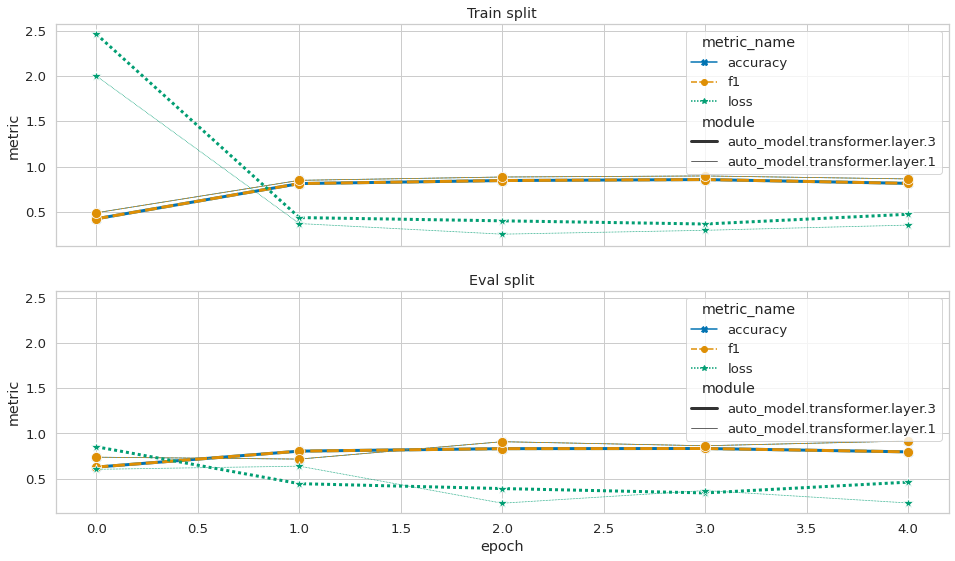

In [8]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.2,
    palette="colorblind",
)

fig, (ax_train, ax_eval) = plt.subplots(2, figsize=(16, 9), sharey=True, sharex=True)

df_train, df_eval, df_test = probing_results.to_pandas(aggregate_by=["batch_index"])

common_kwargs = dict(
    hue="metric_name",
    y="metric",
    x="epoch",
    size="module",
    style="metric_name",
    markers=["X", "o", "*"],
    markersize=10,
    size_order=["auto_model.transformer.layer.3", "auto_model.transformer.layer.1"],
)

sns.lineplot(data=df_train, ax=ax_train, **common_kwargs)
sns.lineplot(data=df_eval, ax=ax_eval, **common_kwargs)

ax_train.set_title("Train split")
ax_eval.set_title("Eval split")

plt.show();

In [9]:
df_test

,epoch,metric_name,module,metric
0,-1,accuracy,auto_model.transformer.layer.1,0.917067
1,-1,accuracy,auto_model.transformer.layer.3,0.776743
2,-1,f1,auto_model.transformer.layer.1,0.917067
3,-1,f1,auto_model.transformer.layer.3,0.776743
4,-1,loss,auto_model.transformer.layer.1,0.247547
5,-1,loss,auto_model.transformer.layer.3,0.451973
